# Polynômes de chaos pour la poutre encastrée ; Sensibilité au degré du polynôme

On considère le cas de la déviation verticale de la poutre encastrée.

Dans ce notebook, on expérimente la sensibilité au degré du polynôme du chaos. On observe comment cela impacte le $Q^2$.

On considère ici un polynôme de chaos creux par moindres carrés avec une règle d'énumération linéaire. Dans un premier temps, on utilise la famille de polynômes orthogonaux pour chaque variable aléatoire, y compris la variable F, de loi log-normale.

On observe que, avec un polynôme de degré total égal à 5, il faut au moins 50 expériences dans l'apprentissage pour estimer le Q2 avec suffisamment de robustesse. Avec un degré égal à 5, si on utilise moins d'expériences, alors il arrive, en fonction de l'échantillon, que le Q2 soit très mauvais (inférieur à 0.5). Avec un plan de taille 25, il est plus prudent d'utiliser un polynôme de degré 2 au plus. Avec un plan de taille 9, même un polynôme de degré 1 peut ne pas produire un Q2 satisfaisant.

La variable log-normale peut poser des difficultés car les polynômes orthogonaux associés ne sont pas denses dans L2. Pour voir si cela a une influence dans ce cas particulier, on utilise des polynômes d'Hermite pour la variable F. Ce choix tend plutôt à dégrader la performance en termes de Q2. Avec un plan d'expériences d'apprentissage de taille 50, la performance se dégrade lorsque le degré du polynôme dépasse 3, ce qui est moins sensible avec la famille des polynômes orthogonalisés pour la loi log-normale.

Ainsi, on observe que, malgré l'algorithme de sélection de modèle LARS utilisé par défaut dans la classe `LeastSquaresMetaModelSelectionFactory`, il est prudent de tester des polynômes de degré croissants pour observer la sensibilité de ce paramètre.

In [1]:
import openturns as ot
import numpy as np
import openturns.viewer
import pylab as plt

La valeur suivante permet d'avoir une simulation rapide.

In [2]:
maxDegree = 2

Pour faire des vrais tests, utiliser plutôt la valeur suivante.

In [26]:
# maxDegree = 7

In [4]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * L ** 3 / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

La fonction suivante calcule un chaos creux par moindres carrés avec une règle d'énumération linéaire associée à un degré total. 

In [5]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Crée un polynôme du chaos creux par moindres carrés. 
    
    Paramètres :
        inputTrain : un Sample, le plan d'expériences des entrées
        outputTrain : un Sample, le plan d'expériences des sorties
        multivariateBasis : une Basis, la base multivariée du chaos
        totalDegree : un entier, le degré total maximal du chaos
        myDistribution : une Distribution, la loi du vecteur aléatoire en entrée
    
    Description :    
        * Utilise la règle d'énumération contenue dans multivariateBasis. 
        * Utilise LeastSquaresStrategy pour calculer les 
        coefficients par moindres carrés. 
        * Utilise LeastSquaresMetaModelSelectionFactory pour 
        obtenir la méthode de sélection de modèle LARS. 
        * Utilise FixedStrategy pour conserver tous les coefficients 
        que la méthode LARS a préalablement sélectionné. 
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

La fonction suivante calcule et affiche le Q2 et produit le diagramme de validation.

In [6]:
def printQ2Chaos(multivariateBasis, chaosResult, inputTest, outputTest, totalDegree):
    sparsityRate = computeSparsityRate(multivariateBasis, totalDegree, chaosResult)
    metamodel = chaosResult.getMetaModel()  # get the metamodel
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    Q2 = max(Q2, 0.0)
    grid = val.drawValidation()
    graph = grid.getGraph(0, 0)
    legend1 = "D=%d, Q2=%.2f%%" % (totalDegree, 100 * Q2)
    graph.setLegends(["", legend1])
    grid.setGraph(0, 0, graph)
    print(
        "Degree=%d, Q2=%.2f%%, Sparsity=%.2f%%"
        % (totalDegree, 100 * Q2, 100 * sparsityRate)
    )
    return graph

La fonction suivante calcule le degré de creux d'un polynôme du chaos en faisant l'hypothèse d'une règle d'énumération linéaire et d'une stratégie de troncature fixe associée un degré maximal donné. Le degré de creux est le ratio entre le nombre de coefficients retenus par la méthode de sélection de modèle et le nombre de coefficients total dans la base polynomiale pleine.

In [7]:
def computeSparsityRate(multivariateBasis, totalDegree, chaosResult):
    """Compute the sparsity rate, assuming a FixedStrategy."""
    # Get P, the maximum possible number of coefficients
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    # Get number of coefficients in the selection
    indices = chaosResult.getIndices()
    nbcoeffs = indices.getSize()
    # Compute rate
    sparsityRate = nbcoeffs / P
    return sparsityRate

In [8]:
def computeQ2Chaos(chaosResult, inputTest, outputTest):
    """Compute the Q2 of a chaos"""
    metamodel = chaosResult.getMetaModel()
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    Q2 = max(Q2, 0.0)
    return Q2

In [9]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)
N = 20  # size of the train design
n_valid = 10000  # size of the test design

La graîne est configurée pour afficher une figure intéressante. 

Degree=1, Q2=96.37%, Sparsity=80.00%
Degree=2, Q2=96.05%, Sparsity=53.33%
Degree=3, Q2=92.37%, Sparsity=28.57%
Degree=4, Q2=76.04%, Sparsity=8.57%
Degree=5, Q2=47.79%, Sparsity=3.17%
Degree=6, Q2=47.79%, Sparsity=1.90%


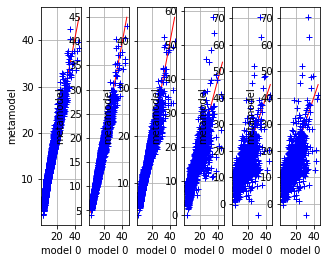

In [10]:
ot.RandomGenerator.SetSeed(43)  # 127 est pas mal non plus
inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)
fig = plt.figure(figsize=(5.0, 4.0))
for totalDegree in range(1, maxDegree):
    chaosResult = ComputeSparseLeastSquaresChaos(
        inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
    )
    graph = printQ2Chaos(
        multivariateBasis, chaosResult, inputTest, outputTest, totalDegree
    )
    ax = fig.add_subplot(1, maxDegree - 1, totalDegree)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

On observe que, lorsque le degré du polynôme augmente, alors le Q2 diminue. On observe aussi que le degré de creux diminue, ce qui montre que l'algorithme de sélection de modèle réalise correctement son travail de choix des coefficients les plus appropriés. Pourtant, cette sélection ne semble pas suffisante pour limiter l'influence du grand nombre de coefficients.

Bien sûr, cet exemple est particulièrement bien choisi pour montrer une dégradation régulière. Comme nous allons le voir, cette dégradation de la performance est en réalité facile à reproduire. 

La boucle suivante recherche la valeur de la graîne permettant de montrer quelque chose d'intéressant.

In [11]:
attemptMax = 10  # Ecrire 1000 pour faire une vraie simulation.
for attempt in range(attemptMax):
    print("Attempt #%d" % (attempt))
    ot.RandomGenerator.SetSeed(attempt)
    inputTrain = myDistribution.getSample(N)
    outputTrain = g(inputTrain)
    inputTest = myDistribution.getSample(n_valid)
    outputTest = g(inputTest)
    Q2array = ot.Sample(maxDegree - 1, 1)
    for totalDegree in range(1, maxDegree):
        chaosResult = ComputeSparseLeastSquaresChaos(
            inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
        )
        Q2array[totalDegree - 1, 0] = computeQ2Chaos(chaosResult, inputTest, outputTest)
    if (Q2array[-1, 0] > 0.1) and (Q2array[-1, 0] < 0.5):
        break

Attempt #0
Attempt #1
Attempt #2
Attempt #3
Attempt #4
Attempt #5
Attempt #6
Attempt #7
Attempt #8
Attempt #9


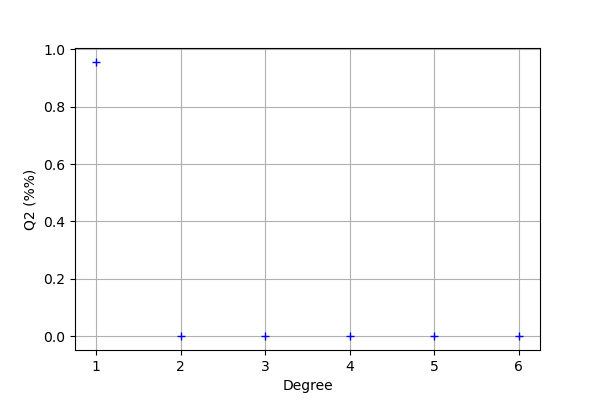

In [12]:
graph = ot.Graph("", "Degree", "Q2 (%%)", True, "topright")
cloud = ot.Cloud(ot.Sample([[x] for x in range(1, maxDegree)]), Q2array)
graph.add(cloud)
graph

Répétons l'expérience pour observer la variabilité du Q2.

In [13]:
def computeSampleQ2(N, n_valid, numberAttempts, maxDegree):
    """For a given sample size N, 
    for degree from 1 to maxDegree, 
    repeat the following experiment numberAttempts times:
    create a sparse least squares chaos and compute the Q2 using n_valid
    """
    Q2sample = ot.Sample(numberAttempts, maxDegree)
    for totalDegree in range(1, maxDegree + 1):
        print("Degree = %d" % (totalDegree))
        for i in range(numberAttempts):
            inputTrain = myDistribution.getSample(N)
            outputTrain = g(inputTrain)
            inputTest = myDistribution.getSample(n_valid)
            outputTest = g(inputTest)
            chaosResult = ComputeSparseLeastSquaresChaos(
                inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
            )
            Q2sample[i, totalDegree - 1] = computeQ2Chaos(
                chaosResult, inputTest, outputTest
            )
    return Q2sample

In [14]:
def plotQ2Boxplots(Q2sample, N):
    data = np.array(Q2sample)
    fig = plt.figure()
    plt.boxplot(data)
    plt.title("N=%d" % (N))
    plt.xlabel("Degree")
    plt.ylabel("Q2 (%)")
    return fig

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


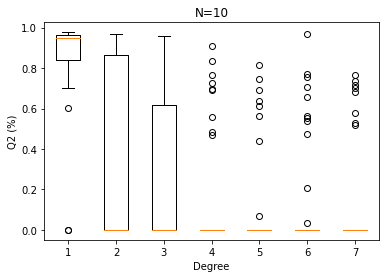

In [15]:
N = 10  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

On observe que, lorsque la taille du plan d'expériences d'apprentissage est d'une taille aussi faible que 10, il est prudent d'utiliser un degré maximal égal à seulement 1.

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


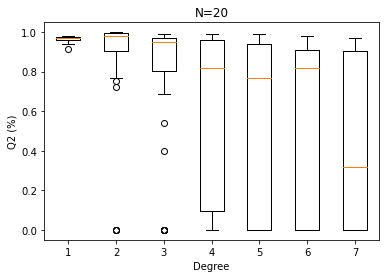

In [16]:
N = 20  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


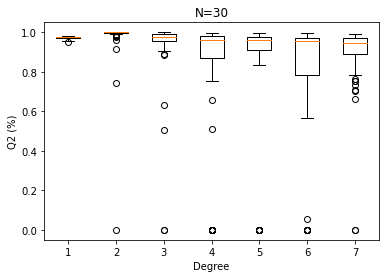

In [17]:
N = 30  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

Avec un plan d'expériences d'apprentissage de taille égale à 30, on peut généralement utiliser un polynôme de degré 3, mais un polynôme de degré 2 donne souvent de meilleurs résutlats.

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


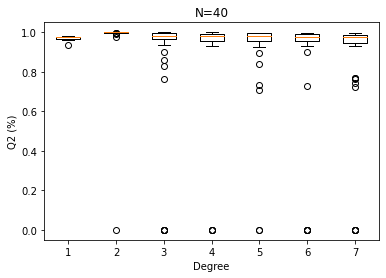

In [18]:
N = 40  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


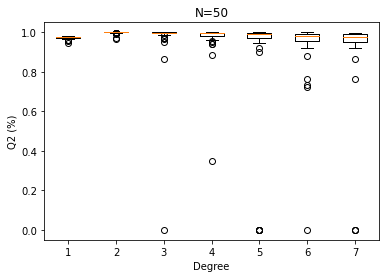

In [19]:
N = 50  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

Lorsque la taille du plan d'expériences d'apprentissage augmente, le calcul du Q2 devient moins sensible au degré du polynôme.

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


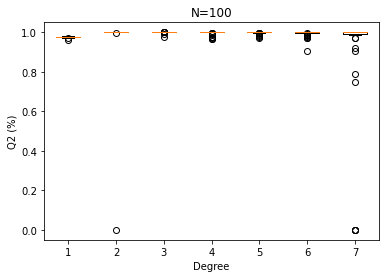

In [20]:
N = 100  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

## Avec des polynômes de Hermite pour la LN

On se demande si la famille de polynômes orthogonaux associé à la loi log-normale peut jouer un rôle. On utilise plutôt des polynômes d'Hermite à la place.

In [21]:
[dist_E, dist_F, dist_L, dist_I]
polyColl = []
polyColl.append(ot.StandardDistributionPolynomialFactory(dist_E))
polyColl.append(ot.HermiteFactory())
polyColl.append(ot.StandardDistributionPolynomialFactory(dist_L))
polyColl.append(ot.StandardDistributionPolynomialFactory(dist_I))
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polyColl)

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


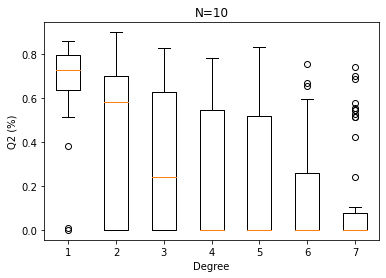

In [22]:
N = 10  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


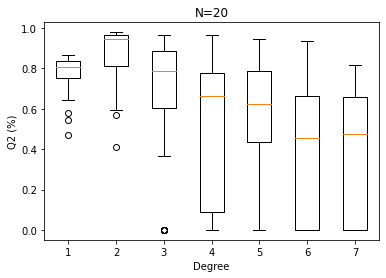

In [23]:
N = 20  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


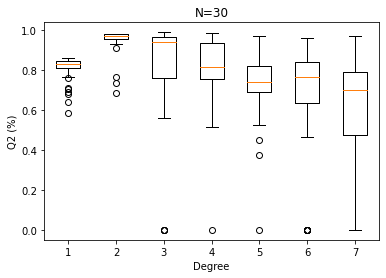

In [24]:
N = 30  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)

Degree = 1
Degree = 2
Degree = 3
Degree = 4
Degree = 5
Degree = 6
Degree = 7


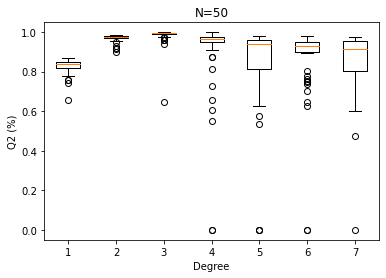

In [25]:
N = 50  # size of the train design
n_valid = 10000  # size of the test design
numberAttempts = 50
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
_ = plotQ2Boxplots(Q2sample, N)